In [149]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yasa

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

events = np.loadtxt('p1_high1_trig.txt', delimiter=',')
# events = np.squeeze(events.values.tolist())
data = np.loadtxt('p1_high1.txt', delimiter=',')

print(events.shape, data.shape)

fs = 256
window_size = 77
channels = 8

(39032,) (39032, 8)


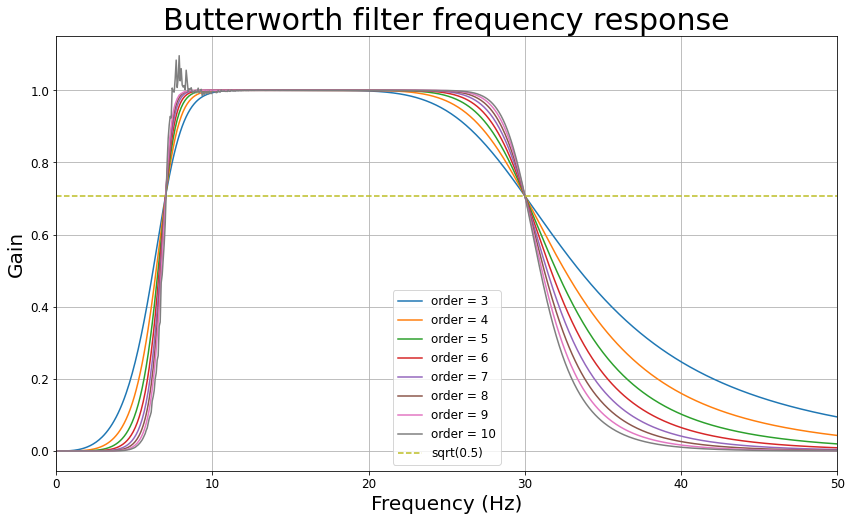

In [150]:
from scipy.signal import welch, freqz, butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# Plot frequency response, spectrum for unfiltered, test it on C3

# Define band
low = 7
high = 30

# Frequency response
plt.figure(1, figsize=(14, 8))
plt.clf()
for order in [3, 4, 5, 6, 7, 8, 9, 10]:
    b, a = butter_bandpass(low-margin, high+margin, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.title("Butterworth filter frequency response", fontsize=30)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.xlim([0, 50])
plt.ylabel('Gain', fontsize=20)
plt.grid(True)
plt.legend(loc='best')



In [158]:
for i in range(data.shape[1]):
    data[:, i] = butter_bandpass_filter(data[:, i], low, high, fs, order=9)


In [159]:
non_target = np.zeros((channels, window_size))
target = np.zeros((channels, window_size))

non_target_count = 0 
target_count = 0

avg_non_target = np.zeros((channels, window_size))
avg_target = np.zeros((channels, window_size))

for i in range(events.shape[0]):
    if (events[i] == 1):
        non_target_count += 1
        trial = data[i: i + window_size, :].T
        non_target = np.append(non_target, trial, axis=1)
        avg_non_target += trial
        
    elif (events[i] == 2):
        target_count += 1
        trial = data[i: i + window_size, :].T
        target = np.append(target, trial, axis=1)
        avg_target += trial
    
    
avg_non_target /= non_target_count
non_target = non_target[:, window_size:]

avg_target /= target_count
target = target[:, window_size:]

all_trials = np.append(target, non_target, axis=1)

print(non_target.shape, all_trials.shape, target_count, non_target_count)

(8, 4620) (8, 9240) 60 60


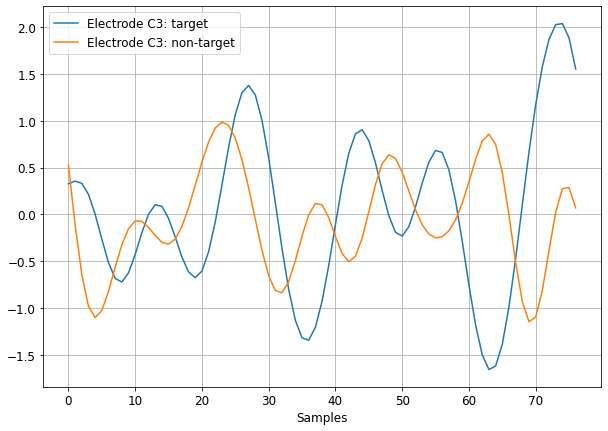

In [161]:
# plot
time = [i for i in range(window_size)]

plt.figure(1, figsize=(10, 7))
plt.clf()
plt.plot(time, avg_target[1, :], label='Electrode C3: target')
plt.plot(time, avg_non_target[1, :], label='Electrode C3: non-target' )

plt.xlabel('Samples')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [162]:
# Create function to process eeg
b = window_size
bp_trials = np.zeros((8, 1))

while (b <= all_trials.shape[1]):
    data = all_trials[:, b-window_size:b]
    data_bp = yasa.bandpower(data, fs, relative=False)['TotalAbsPow']
    data_bp = data_bp.values.reshape((data_bp.shape[0], 1))
    bp_trials = np.append(bp_trials, data_bp, axis=1)
    
    b += window_size
bp_trials = bp_trials[:, 1:]
print(bp_trials.shape)
print(bp_trials)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 77, using nperseg = 77
  warnings.warn('nperseg = {0:d} is greater than input length '


(8, 120)
[[  14.71104674   16.62000976   28.38534124   28.49117012   16.96726538
    31.36983013   25.19400404   40.16198838   18.11842357   15.7091182
    64.55449421   45.11875732    6.21566376   42.76936174   16.26867389
    25.7561151    34.73121424   99.84152583   22.35617029   38.46574198
    49.73658754   15.48586145   43.07849333   41.4971976    51.38205381
    74.53493456   36.47849565   10.51394457   40.5430027    21.04338305
    16.82191576    8.51089182   29.67836571   30.27170606   32.98006863
    41.31982469   26.63872092   27.52968285   26.56809087   10.83700547
     5.56125212   40.63906721    5.65730832   21.50506604   33.66984651
    50.10954109    9.18519704   24.22808015   21.44092644   75.3357903
    18.44217577   27.96144341    8.90236533   18.54682428    8.07877599
    48.76724334   30.02831235   12.575061      8.215564      6.94933535
    39.37744273   45.55856941   18.91458722   40.55268818   21.67774607
    29.86433361   26.45933414   27.38287643   13.4366085 

In [163]:
# create y vector
y = np.concatenate((np.ones(60), np.zeros(60)), axis=0)
print(y, y.shape)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (120,)


[[16 17]
 [14 13]]


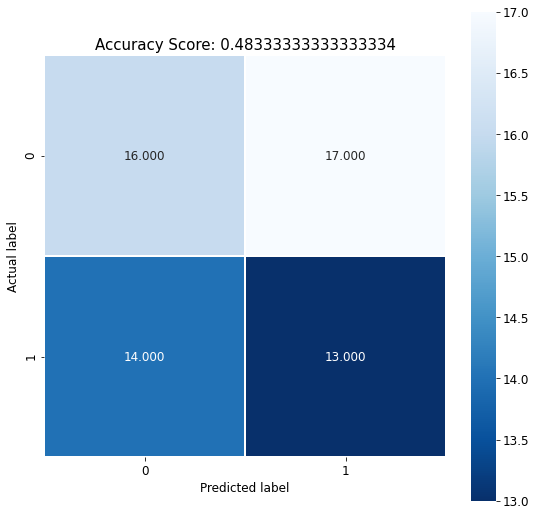

In [164]:
# classify

x_train, x_test, y_train, y_test = train_test_split(bp_trials.T, y, test_size=0.5, shuffle=True, random_state=1)

scaler = StandardScaler()
scaler.fit(x_train)    
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model = LogisticRegression()
model.fit(x_train, y_train)

# Make predictions on entire test set
predictions = model.predict(x_test)

# Use score method to get accuracy of model
score = model.score(x_test, y_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {1}'.format("Neural Net", score)
plt.title(all_sample_title, size = 15);